In [1]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('/Users/Twan/Library/Mobile Documents/com~apple~CloudDocs/Data Science/Data Projects EASI/ENEXIS/src/data/WARP.db')

# Query to get target_datetime and price from master_warp table
df_actual = pd.read_sql_query("""
    SELECT target_datetime, price 
    FROM master_warp
""", conn)

# Convert target_datetime to datetime type
df_actual['target_datetime'] = pd.to_datetime(df_actual['target_datetime'])

# Close the connection
conn.close()

# Display the first few rows to verify the data
print(df_actual.head())

            target_datetime    Price
0 2025-01-01 00:00:00+00:00  0.01362
1 2025-01-01 01:00:00+00:00  0.00624
2 2025-01-01 02:00:00+00:00  0.00416
3 2025-01-01 03:00:00+00:00  0.00328
4 2025-01-01 04:00:00+00:00  0.00068


In [2]:
min_date = pd.Timestamp('2025-03-16', tz='UTC')
max_date = pd.Timestamp('2025-05-23', tz='UTC')

# Filter df_actual based on min_date and max_date
mask = (df_actual['target_datetime'] >= min_date) & (df_actual['target_datetime'] <= max_date)
df_actual = df_actual[mask]

# Display the date range of the filtered data
print(f"Date range of filtered data:")
print(f"Start: {df_actual['target_datetime'].min()}")
print(f"End: {df_actual['target_datetime'].max()}")
print(f"\nNumber of rows: {len(df_actual)}")

Date range of filtered data:
Start: 2025-03-16 00:00:00+00:00
End: 2025-05-23 00:00:00+00:00

Number of rows: 1633


Descriptive Statistics for Price:
count      1633.000000
mean          0.074139
std           0.055117
min          -0.350000
25%           0.046180
50%           0.088720
75%           0.105960
max           0.253350
range         0.603350
variance      0.003038
skewness     -1.331099
kurtosis      5.339300
Name: Price, dtype: float64


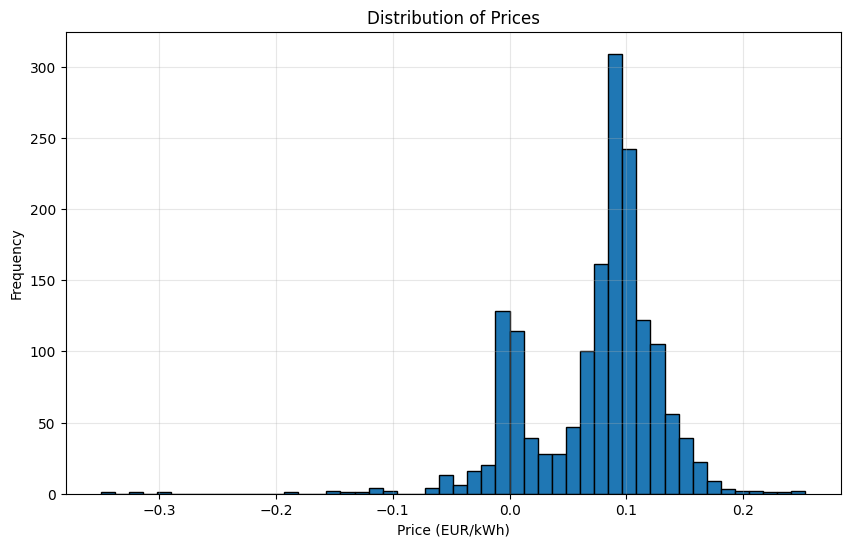

In [19]:
# Calculate descriptive statistics for Price
stats = df_actual['Price'].describe()

# Add additional statistics
stats['range'] = df_actual['Price'].max() - df_actual['Price'].min()
stats['variance'] = df_actual['Price'].var()
stats['skewness'] = df_actual['Price'].skew()
stats['kurtosis'] = df_actual['Price'].kurtosis()

# Display the statistics
print("Descriptive Statistics for Price:")
print(stats)

# Create a histogram of prices
plt.figure(figsize=(10, 6))
plt.hist(df_actual['Price'], bins=50, edgecolor='black')
plt.title('Distribution of Prices')
plt.xlabel('Price (EUR/kWh)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
def find_cheapest_block(df_actual, start_date, horizon_days, block_size=4):
    # Define time window
    end_date = start_date + pd.Timedelta(days=horizon_days)
    mask = (df_actual['target_datetime'] >= start_date) & (df_actual['target_datetime'] < end_date)
    window_data = df_actual[mask]

    # Compute rolling mean
    rolling_means = window_data['Price'].rolling(window=block_size).mean()

    # Find minimum
    min_mean = rolling_means.min()
    min_idx = rolling_means.idxmin() # Get the index of the minimum mean

    if pd.notna(min_mean):
        return {
            'start_date': start_date,
            'horizon_days': horizon_days,
            'block_size': block_size,
            'avg_price': min_mean,
            'block_start_time': df_actual.loc[min_idx, 'target_datetime']
        }
    else:
        return None

# Create analysis for all days and horizons
all_results = []
start_dates = df_actual['target_datetime'].dt.normalize().unique()
last_possible_date = df_actual['target_datetime'].max() - pd.Timedelta(days=1)

for start_date in start_dates:
    if start_date <= last_possible_date:
        for horizon in [1,4,7]:  # 1, 4 or 7 days
            result = find_cheapest_block(df_actual, start_date, horizon)
            if result:
                # Get the block start and end time
                block_start = result['block_start_time']
                block_end = block_start + pd.Timedelta(hours=4)
                all_results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(all_results)


print(results_df.head())

                 start_date  horizon_days  block_size  avg_price  \
0 2025-03-16 00:00:00+00:00             1           4  -0.003310   
1 2025-03-16 00:00:00+00:00             4           4  -0.003532   
2 2025-03-16 00:00:00+00:00             7           4  -0.010407   
3 2025-03-17 00:00:00+00:00             1           4   0.019000   
4 2025-03-17 00:00:00+00:00             4           4  -0.003533   

           block_start_time  
0 2025-03-16 14:00:00+00:00  
1 2025-03-18 14:00:00+00:00  
2 2025-03-22 14:00:00+00:00  
3 2025-03-17 14:00:00+00:00  
4 2025-03-18 14:00:00+00:00  


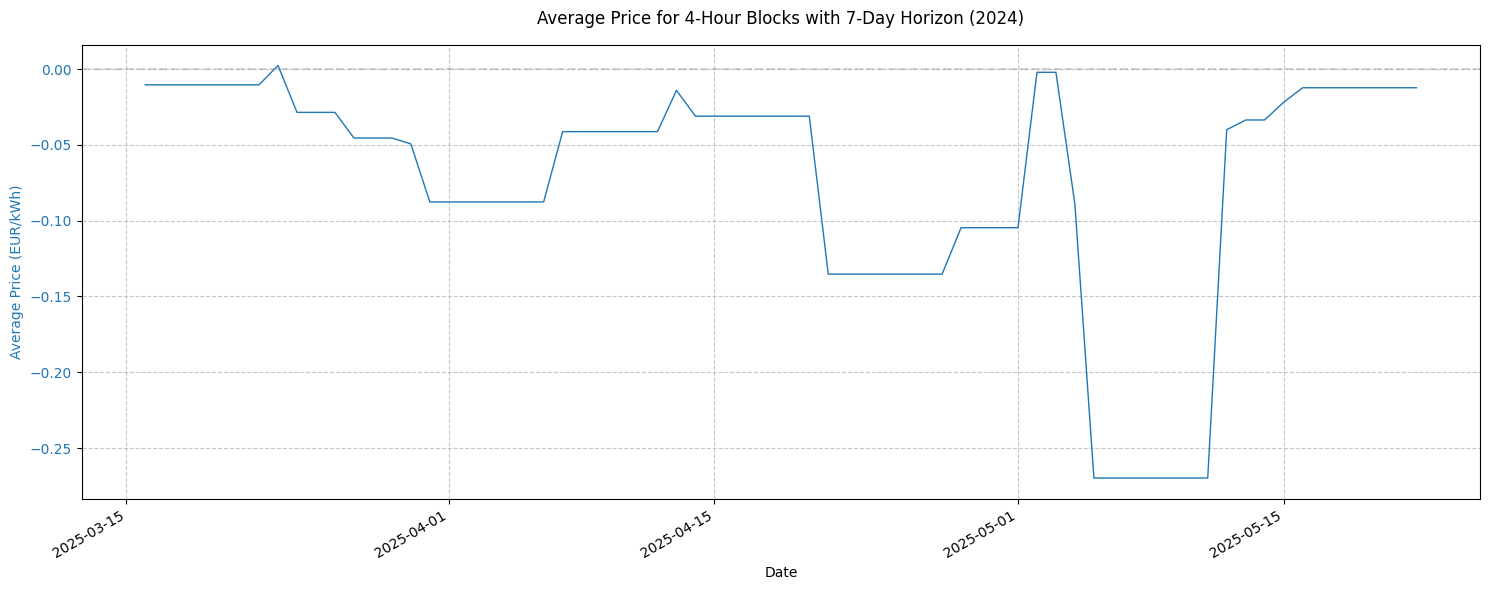

In [5]:
import matplotlib.pyplot as plt

# Filter data for 7-day horizon and 4-hour blocks
horizon7_block4 = results_df[(results_df['horizon_days'] == 7) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon7_block4['start_date'], horizon7_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)



# Customize the plot
plt.title('Average Price for 4-Hour Blocks with 7-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Calculate averages for 7-day horizon blocks
averages = horizon7_block4[['avg_price']].mean()
print("Averages for 7-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")


# Also show standard deviations
std_devs = horizon7_block4[['avg_price']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")


Averages for 7-day horizon, 4-hour blocks:
Average price: -0.07351 EUR/kWh

Standard deviations:
Price std dev: 0.07824 EUR/kWh


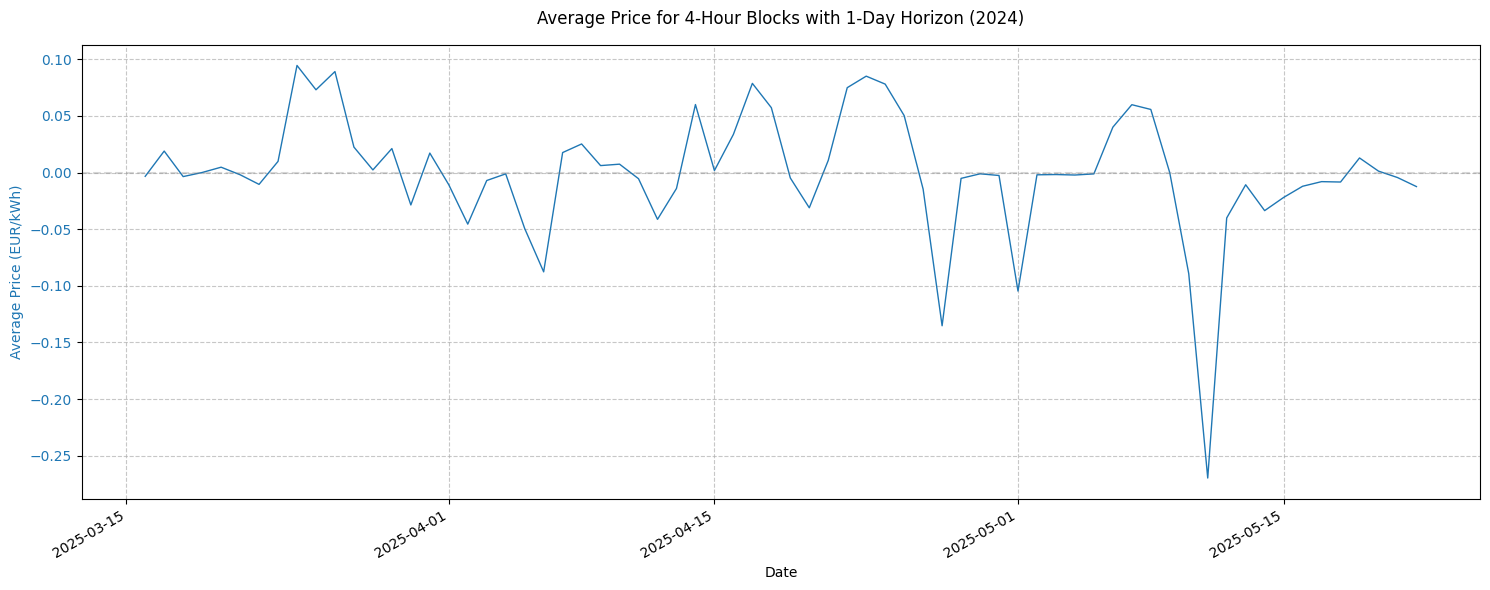

In [7]:
# Filter data for 1-day horizon and 4-hour blocks
horizon1_block4 = results_df[(results_df['horizon_days'] == 1) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon1_block4['start_date'], horizon1_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)


# Customize the plot
plt.title('Average Price for 4-Hour Blocks with 1-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()

In [8]:
# Calculate averages for 1-day horizon blocks
averages = horizon1_block4[['avg_price']].mean()
print("Averages for 1-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")


# Also show standard deviations
std_devs = horizon1_block4[['avg_price']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")


Averages for 1-day horizon, 4-hour blocks:
Average price: -0.00022 EUR/kWh

Standard deviations:
Price std dev: 0.05459 EUR/kWh


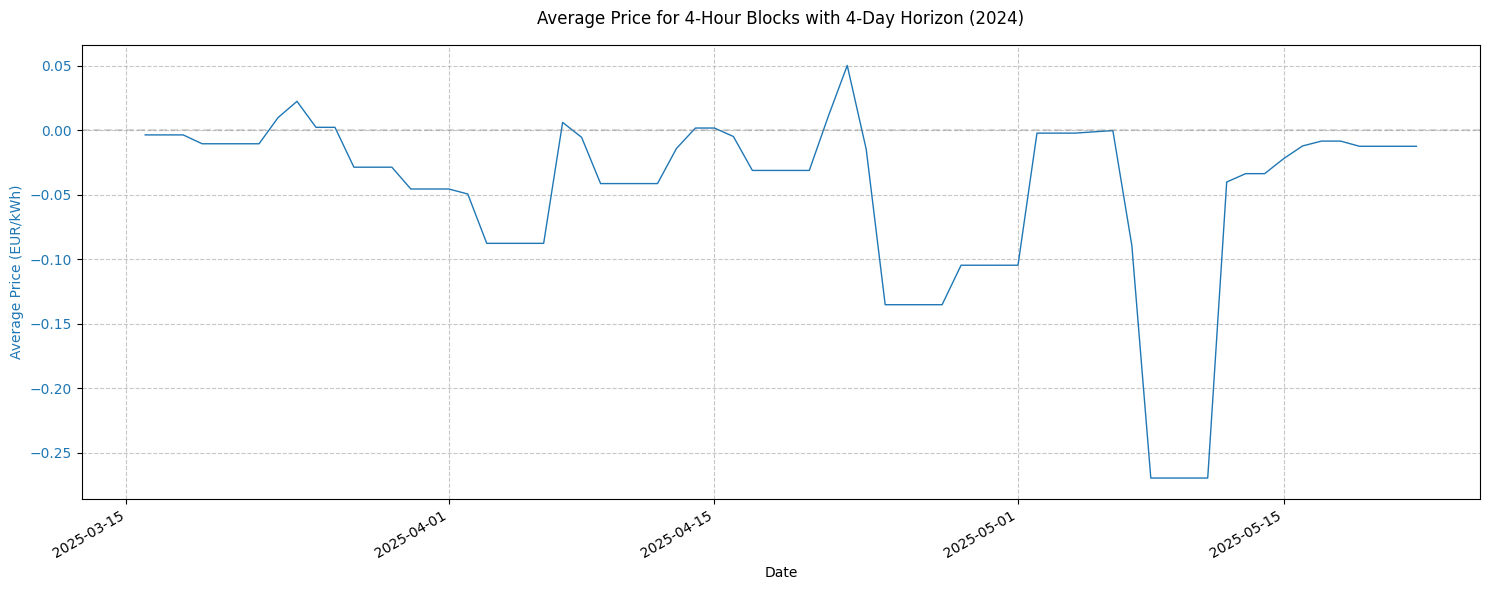

In [9]:
# Filter data for 4-day horizon and 4-hour blocks
horizon4_block4 = results_df[(results_df['horizon_days'] == 4) & (results_df['block_size'] == 4)]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot average price on primary axis
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (EUR/kWh)', color=color1)
ax1.plot(horizon4_block4['start_date'], horizon4_block4['avg_price'], color=color1, linewidth=1)
ax1.tick_params(axis='y', labelcolor=color1)



# Customize the plot
plt.title('Average Price for 4-Hour Blocks with 4-Day Horizon (2024)', pad=15)
plt.grid(True, linestyle='--', alpha=0.7)

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0 for price axis
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()

In [10]:
# Calculate averages for 4-day horizon blocks
averages = horizon4_block4[['avg_price']].mean()
print("Averages for 4-day horizon, 4-hour blocks:")
print(f"Average price: {averages['avg_price']:.5f} EUR/kWh")


# Also show standard deviations
std_devs = horizon4_block4[['avg_price']].std()
print("\nStandard deviations:")
print(f"Price std dev: {std_devs['avg_price']:.5f} EUR/kWh")


Averages for 4-day horizon, 4-hour blocks:
Average price: -0.04762 EUR/kWh

Standard deviations:
Price std dev: 0.06953 EUR/kWh


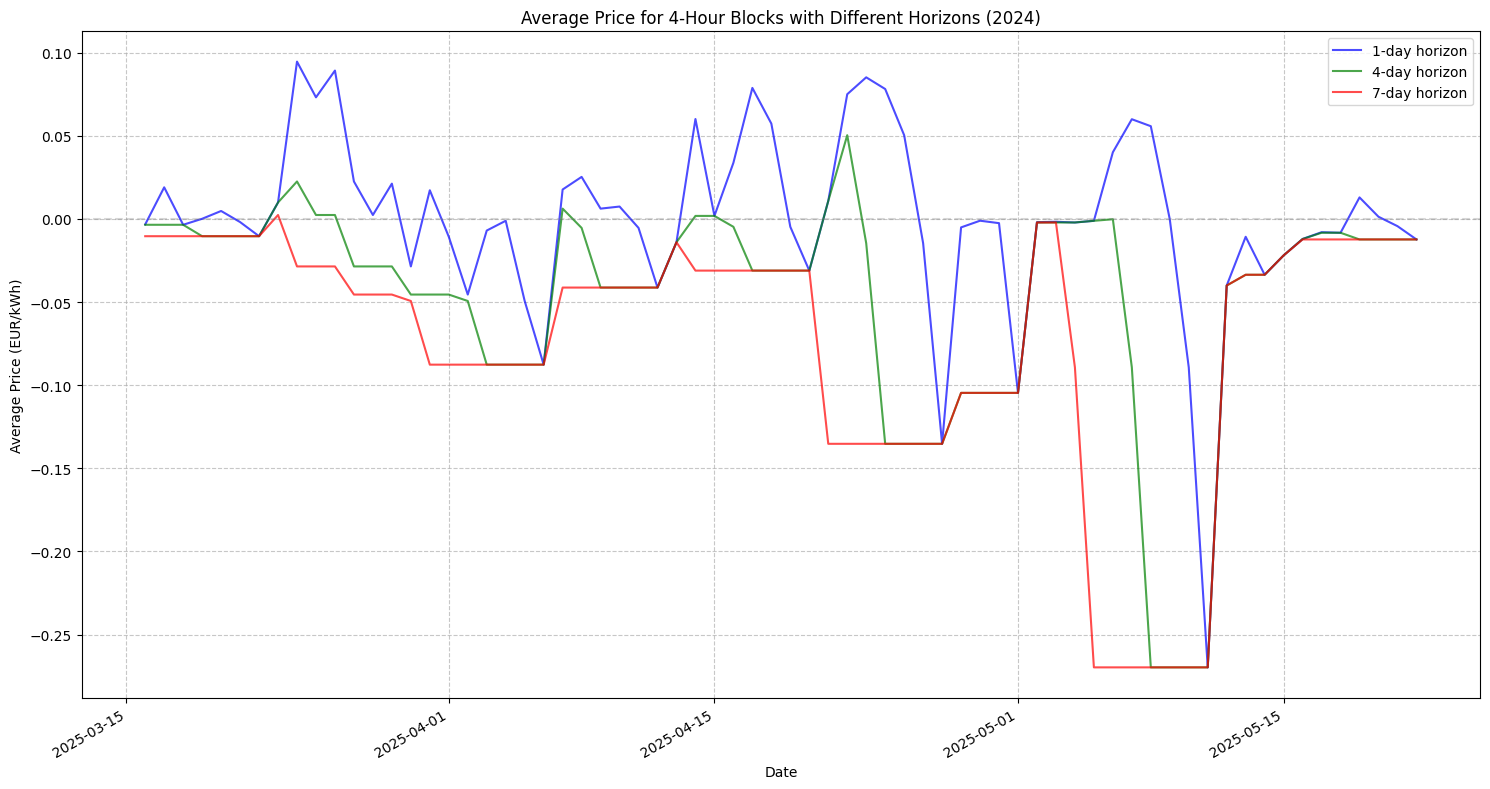

In [11]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Plot data for all three horizons
ax.plot(horizon1_block4['start_date'], horizon1_block4['avg_price'], 
    label='1-day horizon', color='blue', alpha=0.7)
ax.plot(horizon4_block4['start_date'], horizon4_block4['avg_price'], 
    label='4-day horizon', color='green', alpha=0.7)
ax.plot(horizon7_block4['start_date'], horizon7_block4['avg_price'], 
    label='7-day horizon', color='red', alpha=0.7)

# Customize the plot
ax.set_xlabel('Date')
ax.set_ylabel('Average Price (EUR/kWh)')
ax.set_title('Average Price for 4-Hour Blocks with Different Horizons (2024)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Format x-axis to show months
plt.gcf().autofmt_xdate()

# Add horizontal line at y=0
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
        # Calculate mean prices for different horizons and block size 4
    mean_prices = pd.DataFrame()
    for horizon in [1, 4, 7]:
        horizon_data = results_df[
            (results_df['horizon_days'] == horizon) & 
            (results_df['block_size'] == 4)
        ]['avg_price'].mean()
        mean_prices.loc[horizon, 'avg_price'] = horizon_data
    
    # Calculate savings relative to 1 day horizon (baseline)
    baseline_price = mean_prices.loc[1, 'avg_price']
    mean_prices['savings_per_kwh'] = baseline_price - mean_prices['avg_price']
    mean_prices['annual_savings'] = mean_prices['savings_per_kwh'] * 2500
    
   
    print(mean_prices)

    # Store the 1-day horizon price as baseline price
    baseline_price_4h = mean_prices.loc[1, 'avg_price']

    # Print results
    print("\nDetailed price comparison:")
    print(f"Base price (1-day horizon): €{baseline_price_4h:.5f}/kWh")
    print(f"4-day horizon savings: €{mean_prices.loc[4, 'annual_savings']:.2f}/year")
    print(f"7-day horizon savings: €{mean_prices.loc[7, 'annual_savings']:.2f}/year")


   avg_price  savings_per_kwh  annual_savings
1  -0.000221         0.000000        0.000000
4  -0.047619         0.047398      118.495221
7  -0.073506         0.073285      183.211305

Detailed price comparison:
Base price (1-day horizon): €-0.00022/kWh
4-day horizon savings: €118.50/year
7-day horizon savings: €183.21/year


In [17]:
# Base price per kWh (from baseline_price)
base_price = baseline_price_4h

# Additional costs (energy tax value 0.10154 EUR/kWh)
net_energy_tax = 0.10154

# Calculate subtotal
subtotal = base_price + net_energy_tax

# Add 21% VAT
total_with_vat = subtotal * 1.21

print(f"Base price per kWh: €{base_price:.4f}")
print(f"net energy costs per kWh: €{net_energy_tax:.4f}")
print(f"Subtotal per kWh: €{subtotal:.4f}")
print(f"Total price per kWh (incl. 21% VAT): €{total_with_vat:.4f}")

# Calculate annual cost for 2500 kWh
annual_cost_with_vat = total_with_vat * 2500
print(f"\nAnnual cost for 2500 kWh (incl. VAT): €{annual_cost_with_vat:.2f}")



Base price per kWh: €-0.0002
net energy costs per kWh: €0.1015
Subtotal per kWh: €0.1013
Total price per kWh (incl. 21% VAT): €0.1226

Annual cost for 2500 kWh (incl. VAT): €306.49
